# Lab 4 - Comparison of Binary Classifiers

**Student ID:** 17210577 <br>
**Student Name:** Lena Stolz

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier

from scipy import interp

import pickle
import matplotlib.pyplot as plt

### I. Load the dataset + EDA (Exploratory Data Analysis)

In [3]:
dataFrame = pd.read_csv("./seeds.csv")

dataFrame.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [4]:
dataFrame['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

In [5]:
dataFrame.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

After we check for missing values we crreate a box plot to check for outliers.

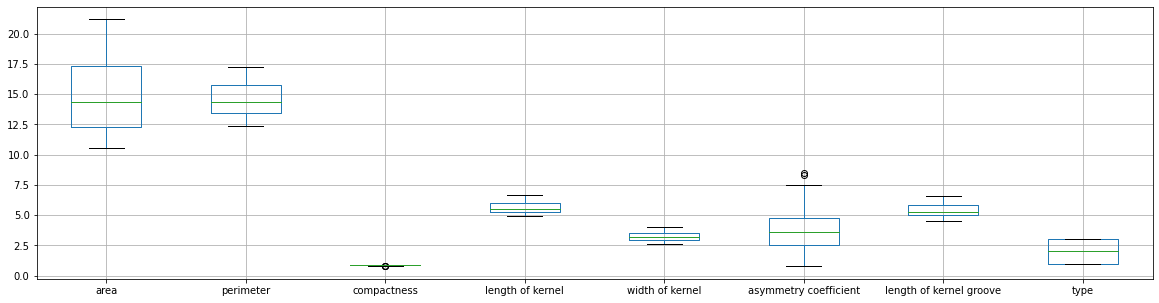

In [6]:
dataFrame.boxplot(figsize = (20,5))
plt.show()

## II. Data Preparation

First, we transform the `type` column to binary and then check the value counts to see how the data has changed after the transformation.

In [7]:
mapper = {1 : 1, 2 : 0, 3: 0}
dataFrame['type'] = dataFrame['type'].replace(mapper)

In [8]:
dataFrame['type'].value_counts()

0    140
1     70
Name: type, dtype: int64

Next we store a list with the names of all predictors and define the column groups with the same data preparation.

In [10]:
names_all = [c for c in dataFrame if c not in ['type']]

names_outliers = ['asymmetry coefficient','compactness']
names_no_outliers = list(set(names_all) - set(names_outliers))

In [11]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [12]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [13]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

In [14]:
y = dataFrame['type']
X = dataFrame.drop('type', axis = 1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

## III. Grid Search for Best Parameters of Classifiers

**SVM Classifier**

In [15]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

param_grid = {
    'svm__C': [0.1, 1, 10, 50, 100, 200],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, cv = 10, refit = True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.959:
Best parameters:  {'svm__C': 10, 'svm__gamma': 1, 'svm__kernel': 'linear'}


**Random Forest Classifier**

In [16]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

param_grid = {
    'rf__n_estimators' : [10,15,20,30,50],
    'rf__max_depth': [2, 4, 6, 8, 10]
}

search = GridSearchCV(pipe, param_grid, cv = 10, refit = True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.940:
Best parameters:  {'rf__max_depth': 8, 'rf__n_estimators': 30}


**KNN Classifier**

In [17]:
from sklearn.neighbors import KNeighborsClassifier

pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', KNeighborsClassifier())])

param_grid = {
    'knn__weights' : ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

search = GridSearchCV(pipe, param_grid, cv = 10, refit = True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.922:
Best parameters:  {'knn__algorithm': 'auto', 'knn__weights': 'uniform'}


## IV. Comparison

In [18]:
mean_fpr = np.linspace(start = 0, stop = 1, num = 100)

In [19]:
def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [20]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, KNN_best_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


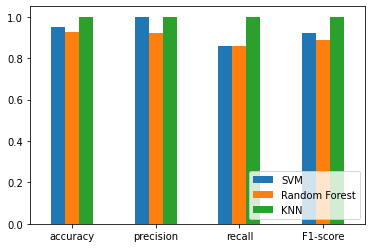

In [21]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])


index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics,'KNN': KNN_metrics}, index = index)
df_metrics.plot.bar(rot = 0)
plt.legend(loc = "lower right")
plt.show()

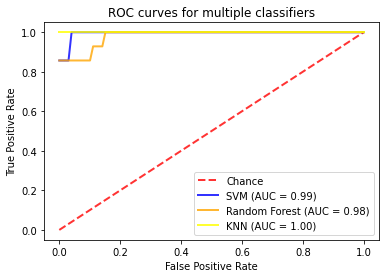

In [22]:
plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = 'Chance', alpha = 0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw = 2, color = 'blue', label = 'SVM (AUC = %0.2f)' % (SVM_auc), alpha = 0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw = 2, color = 'orange', label = 'Random Forest (AUC = %0.2f)' % (RF_auc), alpha = 0.8)
plt.plot(mean_fpr, KNN_tpr[0,:], lw = 2, color = 'yellow', label = 'KNN (AUC = %0.2f)' % (KNN_auc), alpha = 0.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc = "lower right")
plt.show()

## V. Train final model

In [23]:
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)

## VI. Conclusion



* SVM classifier is most accurate
* KNN classifier is second most accurate
* Random Forest falls last in comparison to previous classifiers
* ROC however shows that all models are noticeable more accurate than chance.


